## Testing with images taken on an OpenFlexure Microscope

In [26]:
# Imports
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, concatenate, Dense, Average, Dropout, LeakyReLU, Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Lambda, Activation, Flatten, Convolution1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import np_utils
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras_squeezenet_tf2 import SqueezeNet
from keras_squeezenet_tf2 import SqueezeNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [27]:
import glob
from PIL import Image 
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

filelist = glob.glob('../data/testing_openflexure/cells/*.jpeg')
filelist

['../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_985_615_1219_840.jpeg',
 '../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_429_179_671_426.jpeg',
 '../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_143_771_358_975.jpeg',
 '../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_807_415_1052_667.jpeg',
 '../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_930_1087_1199_1328.jpeg',
 '../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_317_806_558_1042.jpeg',
 '../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_1046_692_1274_937.jpeg',
 '../data/testing_openflexure/cells/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_2000_1280_1280_0_88_806_322_1048.jpeg',
 '../data/testing_openflexure/cells/slice_2021-0

In [28]:
# very complicated way to plot
# https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally
from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

In [29]:
#%% Loading the data

img_width, img_height = 100, 100
train_data_dir = '../data/cell_images/train'
validation_data_dir = '../data/cell_images/test'
epochs = 60
batch_size = 16 
num_classes= 2

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (100,100,3)
model_input = Input(shape=input_shape)
print(model_input) 

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [30]:
#%% define custom model and instantiate it

def custom_cnn(model_input):
    x = BatchNormalization()(model_input)
    x = Conv2D(64, (5, 5), padding='same', activation='relu', name = 'custom_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name = 'maxpool1')(x)
    x = Dropout(0.25, name = 'conv_dropout1')(x)
    x = BatchNormalization(name = 'custom_batchnorm1')(x)
    x = Conv2D(128, (5, 5), padding='same', activation='relu', name = 'custom_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool2')(x)
    x = Dropout(0.25, name = 'conv_dropout2')(x)
    x = BatchNormalization(name = 'custom_batchnorm2')(x)
    x = Conv2D(256, (5, 5), padding='same', activation='relu', name = 'custom_conv3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool3')(x)
    x = Dropout(0.25, name = 'conv_dropout3')(x)
    x = GlobalAveragePooling2D(name = 'custom_GAP')(x)
    x = Dense(256, activation='relu', name = 'custom_dense1')(x)
    x = Dropout(0.5, name = 'dense_dropout1')(x)
    x = Dense(num_classes, activation='softmax', name = 'custom_dense2')(x)
    model = Model(inputs=model_input, outputs=x, name='custom_cnn')
    return model

#instantiate the model
custom_model = custom_cnn(model_input)

#display model summary
custom_model.summary()

#plot the model
#plot_model(custom_model, to_file='custom_model.png',show_shapes=True, show_layer_names=False)


Model: "custom_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
batch_normalization_612 (Bat (None, 100, 100, 3)       12        
_________________________________________________________________
custom_conv1 (Conv2D)        (None, 100, 100, 64)      4864      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 50, 50, 64)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 50, 50, 64)        0         
_________________________________________________________________
custom_batchnorm1 (BatchNorm (None, 50, 50, 64)        256       
_________________________________________________________________
custom_conv2 (Conv2D)        (None, 50, 50, 128)       2

In [31]:
#%% VGG19 model 

def vgg19_cnn(model_input):
    vgg19_cnn = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    x = vgg19_cnn.layers[-2].output 
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19_cnn.input, outputs=predictions, name='vgg19_custom')
    return model

#instantiate the model
vgg19_custom_model = vgg19_cnn(model_input)

#plot model summary
vgg19_custom_model.summary()
#plot_model(vgg19_custom_model, to_file='vgg19_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "vgg19_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [32]:

#%% SqueezeNet 

def squeeze_cnn(model_input):
    squeeze_cnn = SqueezeNet(weights='imagenet', include_top=False, input_tensor=model_input)
    x = squeeze_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=squeeze_cnn.input, outputs=predictions, name='squeeze_custom')
    return model

#instantiate the model
squeeze_custom_model = squeeze_cnn(model_input)

#display model summary
squeeze_custom_model.summary()

#plot model
#plot_model(squeeze_custom_model, to_file='squeeze_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "squeeze_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
_____________________________________________________________________________________

In [33]:
#%% Inception ResnetV2 

def incepres_cnn(model_input):
    incepres_cnn = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    x = incepres_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=incepres_cnn.input, outputs=predictions, name='InceptionResnet_custom')
    return model

#instantiate the model
inceptionresnet_custom_model = incepres_cnn(model_input)

#display model summary
inceptionresnet_custom_model.summary()

#plot model
#plot_model(inceptionresnet_custom_model, to_file='inceptionresnet_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "InceptionResnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_609 (Conv2D)             (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_613 (BatchN (None, 49, 49, 32)   96          conv2d_609[0][0]                 
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 49, 49, 32)   0           batch_normalization_613[0][0]    
_____________________________________________________________________________

batch_normalization_769 (BatchN (None, 4, 4, 256)    768         conv2d_765[0][0]                 
__________________________________________________________________________________________________
batch_normalization_771 (BatchN (None, 4, 4, 256)    768         conv2d_767[0][0]                 
__________________________________________________________________________________________________
batch_normalization_774 (BatchN (None, 4, 4, 288)    864         conv2d_770[0][0]                 
__________________________________________________________________________________________________
activation_765 (Activation)     (None, 4, 4, 256)    0           batch_normalization_769[0][0]    
__________________________________________________________________________________________________
activation_767 (Activation)     (None, 4, 4, 256)    0           batch_normalization_771[0][0]    
__________________________________________________________________________________________________
activation

In [34]:
#%% construct the ensemble model
custom_model = custom_cnn(model_input)
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)
inceptionresnet_custom_model = incepres_cnn(model_input)

#load the best weights
custom_model.load_weights('weights/custom_cnn.h5')
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

In [35]:
#append the models to the list

models = [custom_model, vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

In [36]:
#%% Other Possible Ensembles: 
# We can select the optimal ensemble from the collection of model combinations

pair_A = [custom_model, vgg19_custom_model]
pair_B = [custom_model, squeeze_custom_model]
pair_C = [custom_model, inceptionresnet_custom_model]
pair_D = [vgg19_custom_model, squeeze_custom_model]
pair_E = [vgg19_custom_model, inceptionresnet_custom_model]
pair_F = [squeeze_custom_model, inceptionresnet_custom_model]
pair_G = [custom_model, vgg19_custom_model, squeeze_custom_model]
pair_H = [custom_model, vgg19_custom_model, inceptionresnet_custom_model]
pair_I = [vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

In [37]:
imgs = [cv2.resize(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGRA2BGR), (100, 100)) for fname in filelist]

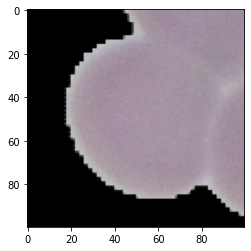

In [38]:
plt.imshow( imgs[3])

In [39]:
test_images = np.array([np.array(img) for img in imgs])

In [40]:
#%% construct the ensemble model
custom_model = custom_cnn(model_input)
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)
inceptionresnet_custom_model = incepres_cnn(model_input)

#load the best weights
custom_model.load_weights('weights/custom_cnn.h5')
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

In [41]:
#%% Pair D

#pair_D_ensemble_model = ensemble(pair_D, model_input)


#evaluate accuracy
pred = vgg19_custom_model.predict(test_images, workers=1)

In [42]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



def plot_image(i, predictions_array, img):
    img = img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == 1:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[predicted_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [43]:
test_labels = [0] * len(filelist)
class_names = ['Parasitized', 'Uninfected']

In [44]:
pred

array([[0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [2.4136122e-07, 9.9999976e-01],
       [1.1783511e-11, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [5.3335839e-36, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.9999201e-01, 8.0359532e-06],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.6414527e-29, 1.


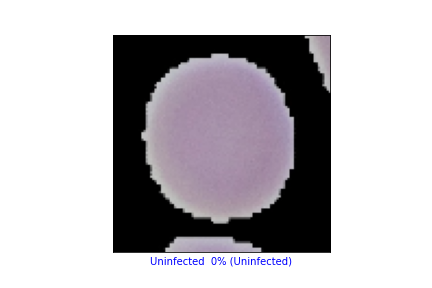
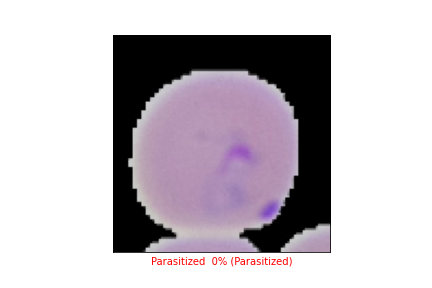
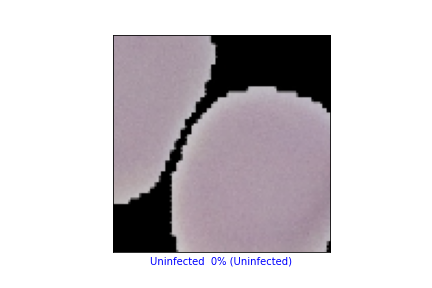
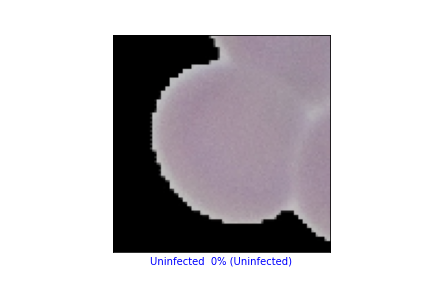
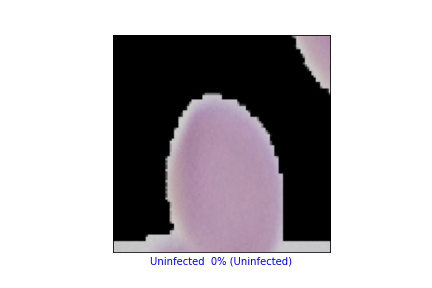
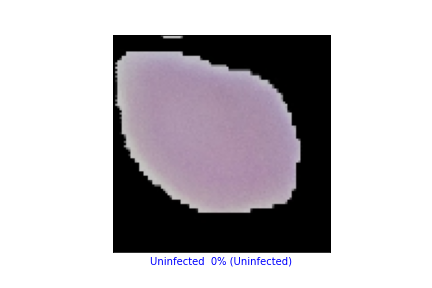
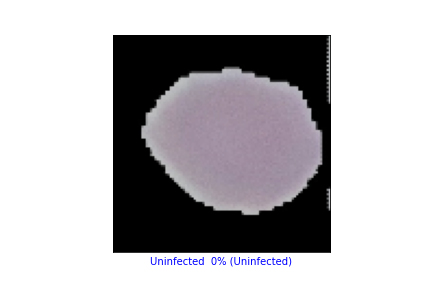
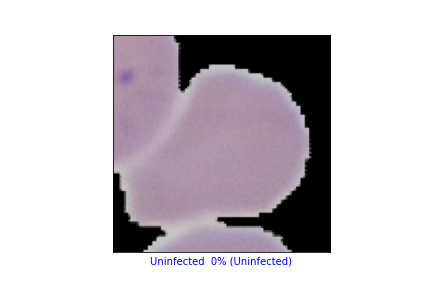
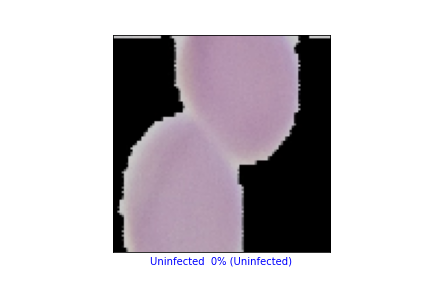
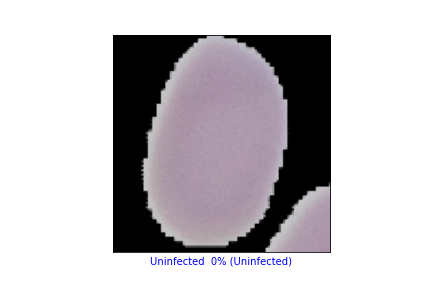
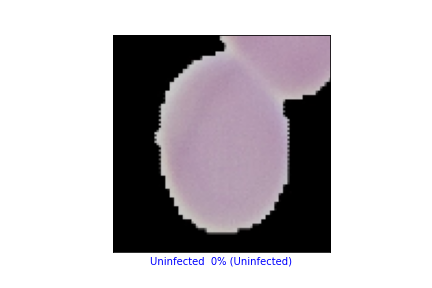
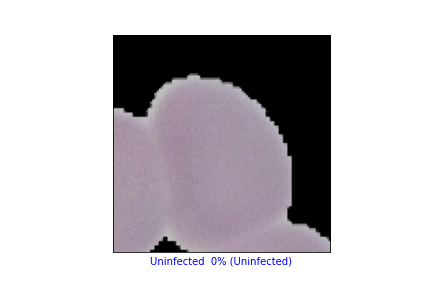
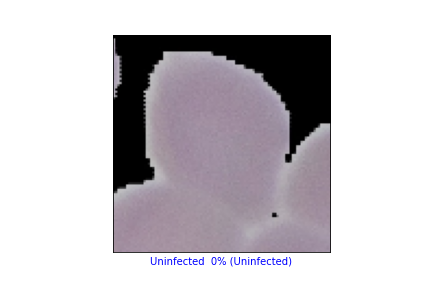
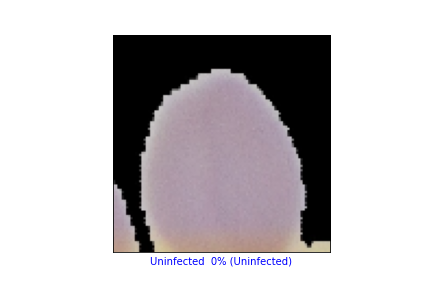
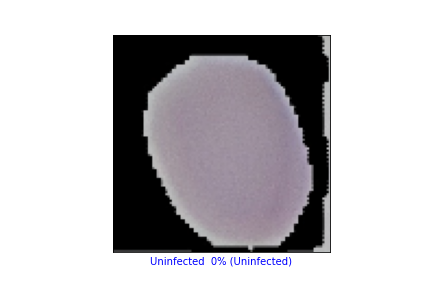
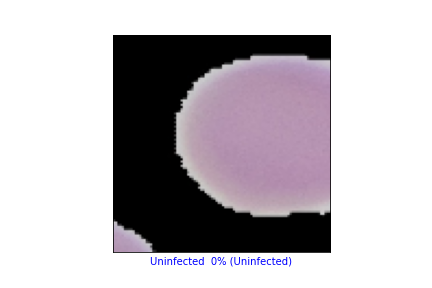
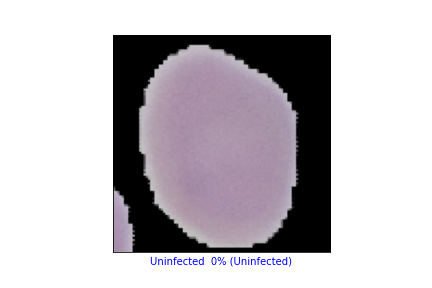
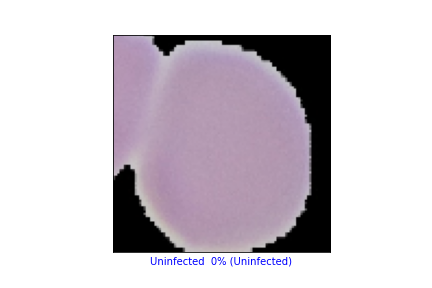
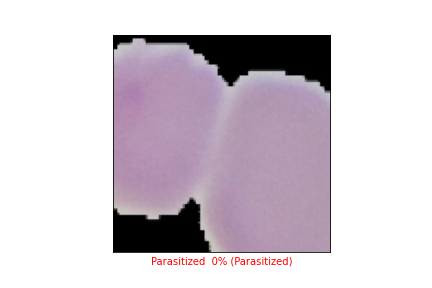
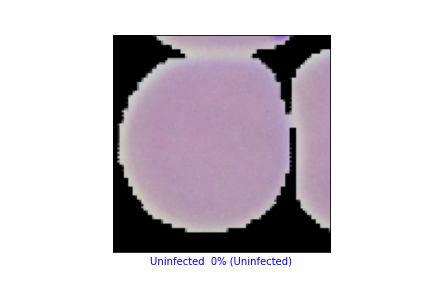
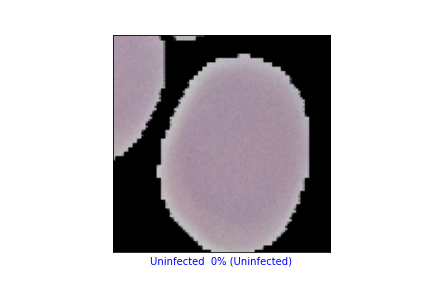
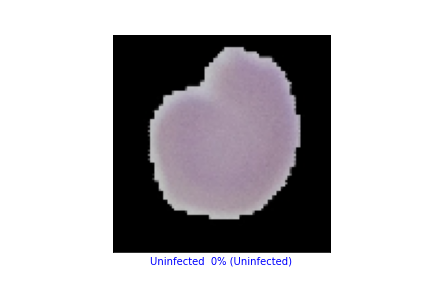
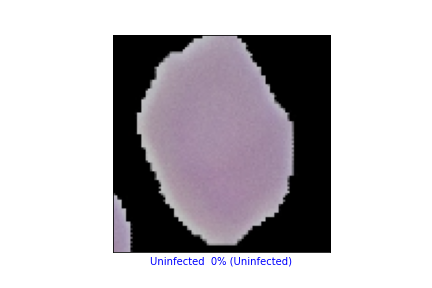
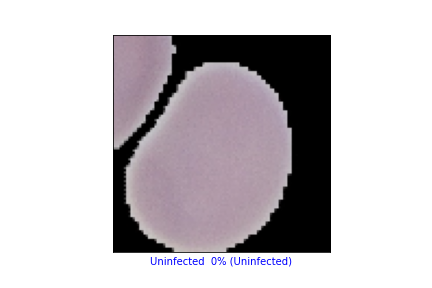
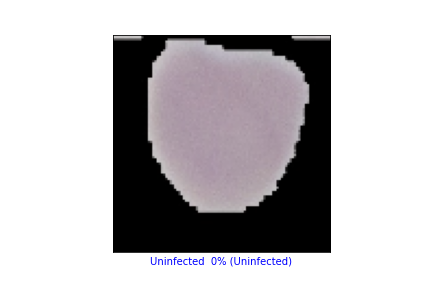
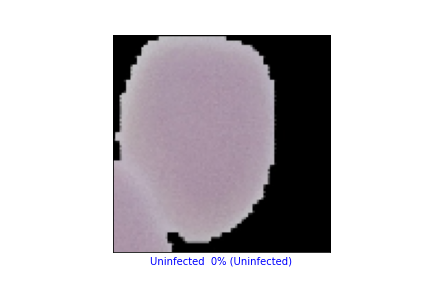
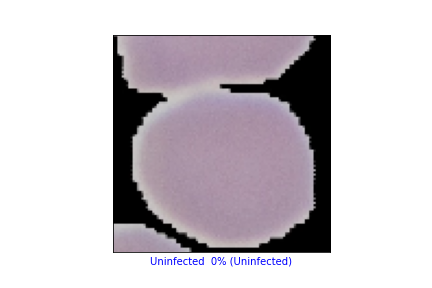
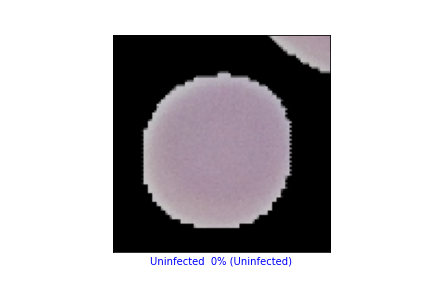
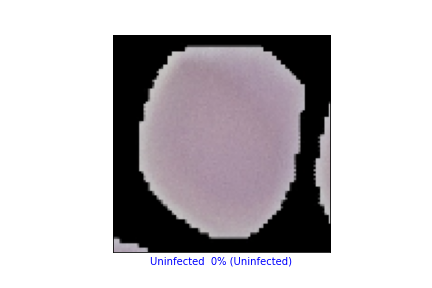
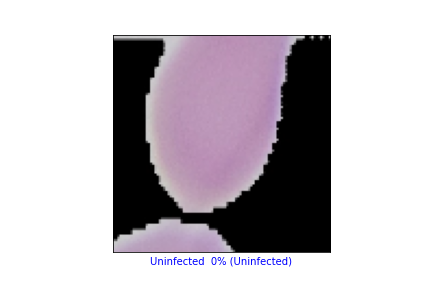
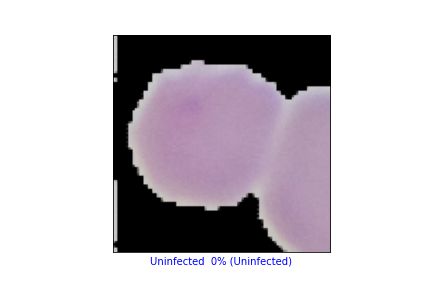
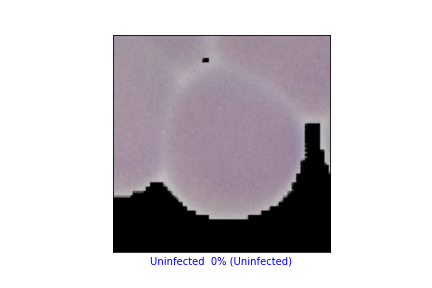
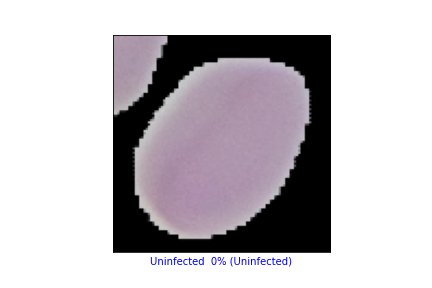
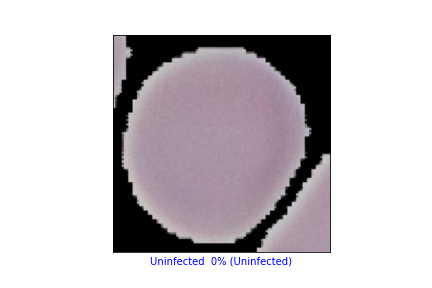
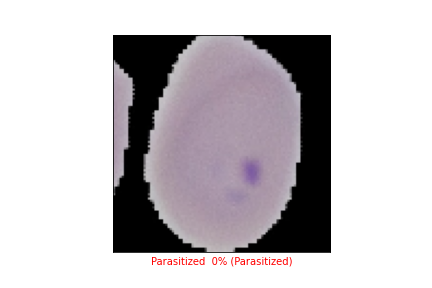
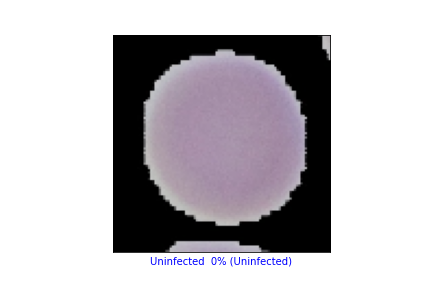
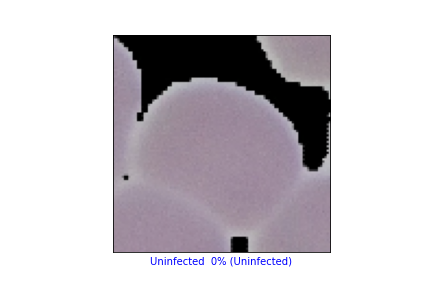
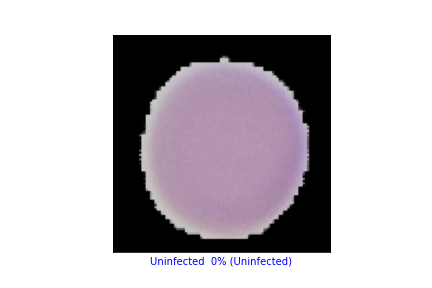
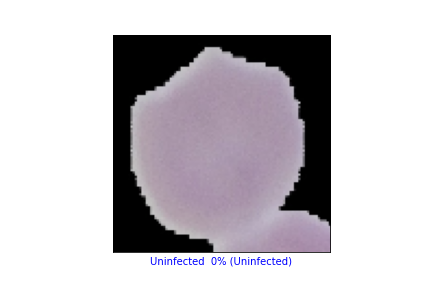
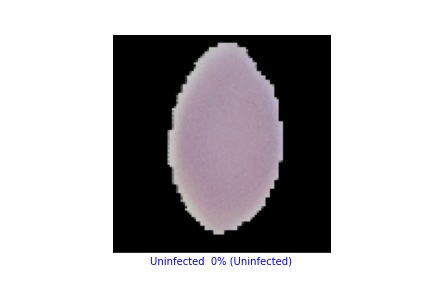
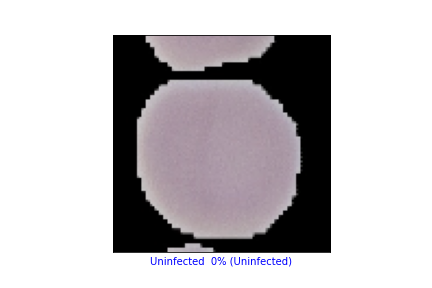
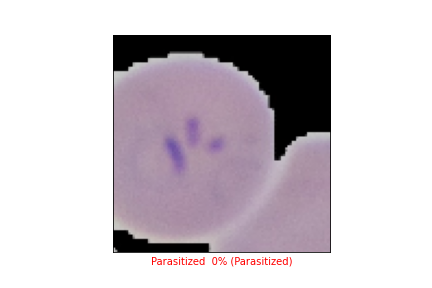
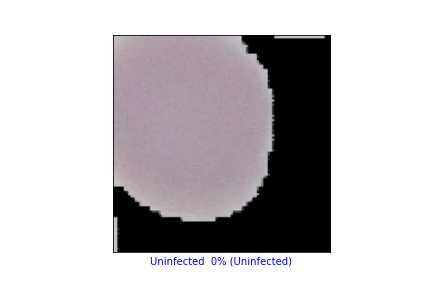
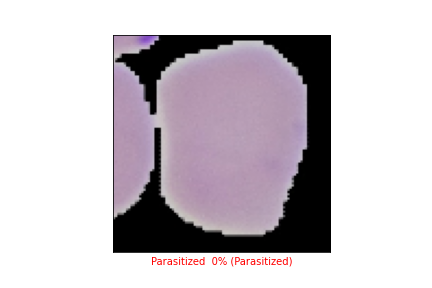
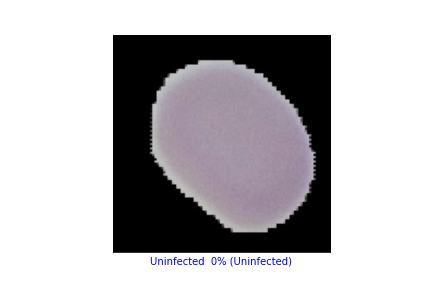
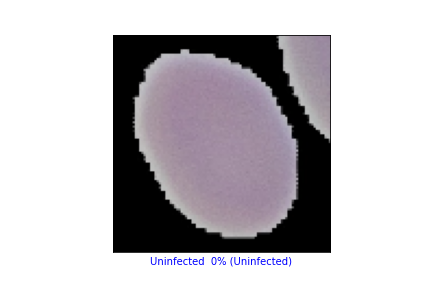
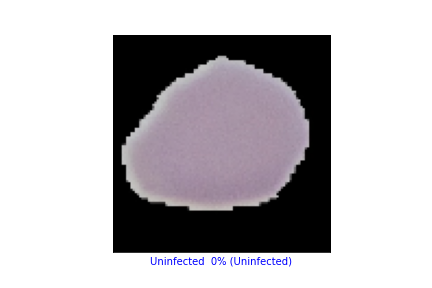
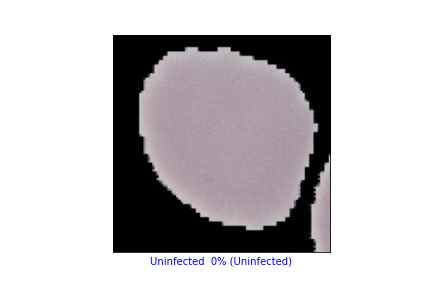
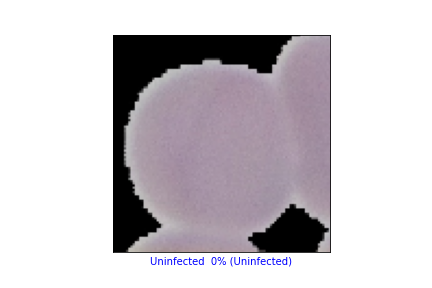
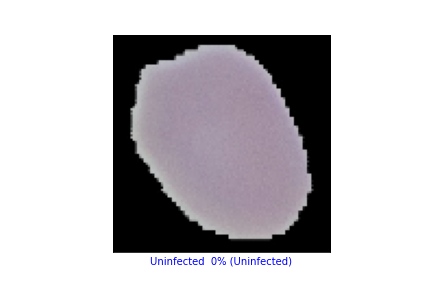
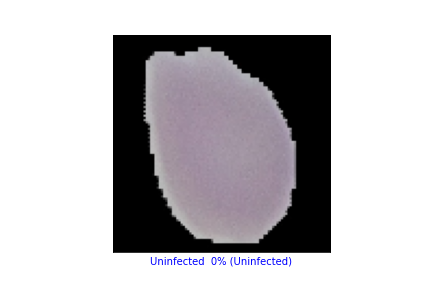
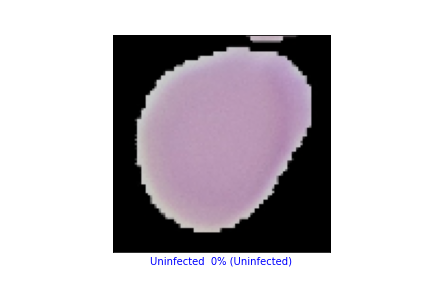
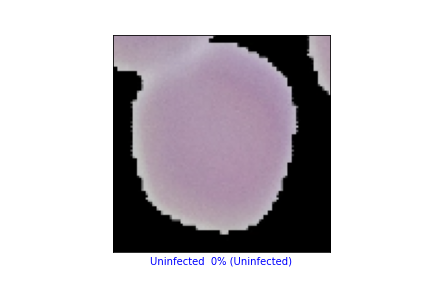
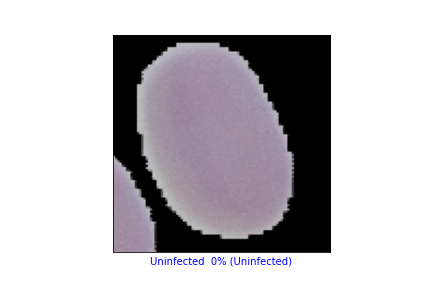
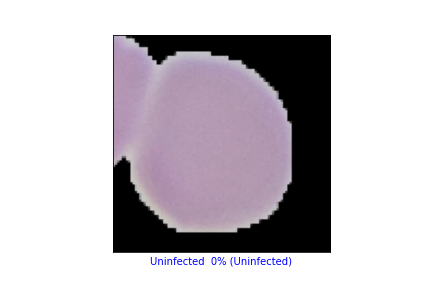
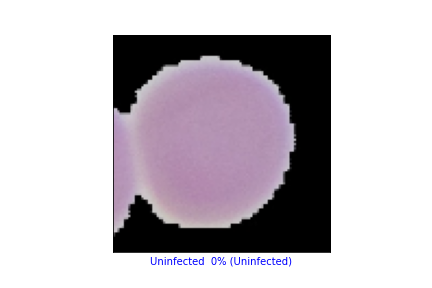
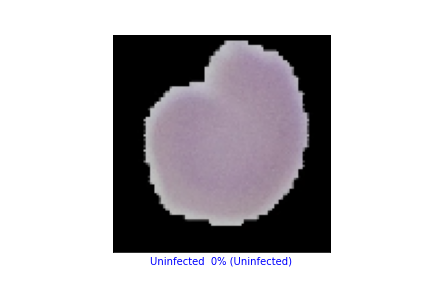
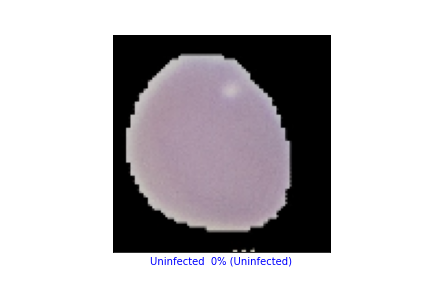
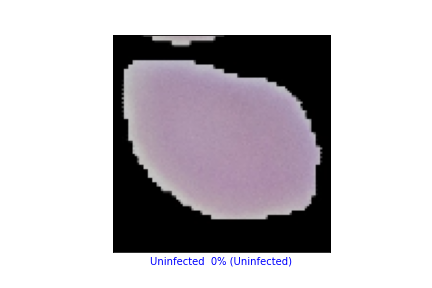
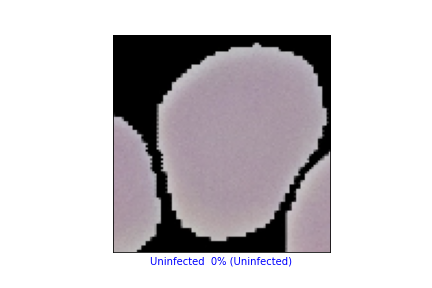
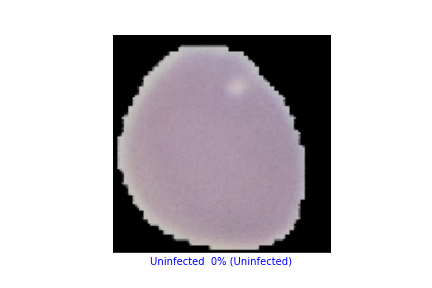

In [45]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout
output_dir =  '../data/testing_openflexure/predictions/'

for i in range(0, len(filelist)):
    img = test_images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    filename, ext = os.path.splitext(os.path.basename(filelist[i]))
    
    try:
        os.makedirs(output_dir)   
    except FileExistsError:
        pass

    predicted_label = np.argmax(pred[i])
    if predicted_label == 1:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(test_labels),
                                class_names[predicted_label]),
                                color=color)
    oPlot.add_plot(plt.imshow(img, cmap=plt.cm.binary))
    filelist[i]
    
    plt.savefig( output_dir + filename + '_' + str(i) + '.jpeg')
    
    plt.close() 
    

oPlot.PassHtmlToCell()